In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import layers, models
from keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, Dropout, \
    Attention
from keras import *
from keras.applications import MobileNet
from keras.applications import VGG16
from keras.applications.resnet import ResNet50
from keras import backend as K
from keras.layers import Layer
import keras.layers as kl
import pandas as pd
from keras.applications import EfficientNetB0
import keras.applications
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import pickle
import tensorflow_addons as tfa
from sklearn import metrics
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.models import load_model
import os
import glob

c:\Users\raouf\miniconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\raouf\miniconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

In [2]:
main_save_path = "C:/Users/raouf/Desktop/pfe/history/final/densenet/"
mura_location = "C:/Users/raouf/Desktop/pfe/"
data_path = 'C:/Users/raouf/Desktop/pfe/MURA-v1.1/'
train_path = 'C:/Users/raouf/Desktop/pfe/MURA-v1.1/train'
test_path = 'C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid'

train_file = "C:/Users/raouf/Desktop/pfe/datasets/shoulder_df_train.csv"
val_file = "C:/Users/raouf/Desktop/pfe/datasets/shoulder_df_valid.csv"

test_file = "C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid_image_paths.csv"

target_category = "XR_SHOULDER"
batch_size = 16
num_epochs = 100
fine_tuning_epochs=50
validation_split = 0.2
loss_function = tf.keras.losses.BinaryCrossentropy()
learning_rate = 0.0001
input_shape = (224, 224, 3)
architecture = 'DenseNet'

include_top = False
# metrics=["accuracy"] #, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
early_stopping_patience = 15
shuffle = True
class_mode = 'binary'  # 'categorical'
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
trainable = False
training = False
dropout = 0.2

In [3]:
def load_data(file, part):
    train_data = pd.read_csv(file)
    train_data = train_data.rename(columns={train_data.columns[0]: 'image_path'})
    train_data['label'] = 2
    string_to_add = mura_location
    train_data['image_path'] = string_to_add + train_data['image_path'].astype(str)
    for index, row in train_data.iterrows():
        if 'positive' in str(row['image_path']).lower():
            train_data.at[index, 'label'] = "positive"
        else:
            train_data.at[index, 'label'] = "negative"

    if part == 0:
        pass
    else:
        train_data = train_data[train_data['image_path'].str.contains(part)]
    return train_data


class CustomCallback(keras.callbacks.Callback):
    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print(f"tp          :", logs["tp"])
        print(f"fp          :", logs["fp"])
        print(f"tn          :", logs["tn"])
        print(f"fn          :", logs["fn"])
        print(f"binary_acc  :", logs["binary_acc"])
        print(f"precision   :", logs["precision"])
        print(f"recall      :", logs["recall"])
        print(f"f1_score    :", logs["f1_score"])
        print(f"roc_auc     :", logs["roc_auc"])
        print(f"pr_auc      :", logs["pr_auc"])
        print(f"cohen_kappa :", logs["cohen_kappa"])

class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)


def save_history(name,history_df):

    history_excel_path = (
            save_path +
            name +
            '_history'
            '.xlsx'
    )

    history_df.to_excel(history_excel_path, index=False)
    print("Training history saved to:", history_excel_path)






def plot_metrics(history: tf.keras.callbacks.History,
                 metrics: list = ["loss", "cohen_kappa", "precision", "recall"],
                 ) -> None:
    plt.rcParams["figure.figsize"] = (18, 15)

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(
            history.epoch, history.history[metric], linewidth=1.8, label="training"
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            linestyle="--",
            linewidth=1.8,
            label="validation",
        )
        plt.xlabel("epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "cohen_kappa":
            plt.ylim([-1, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()



class CustomCallback(keras.callbacks.Callback):
    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print(f"tp          :", logs["tp"])
        print(f"fp          :", logs["fp"])
        print(f"tn          :", logs["tn"])
        print(f"fn          :", logs["fn"])
        print(f"binary_acc  :", logs["binary_acc"])
        print(f"precision   :", logs["precision"])
        print(f"recall      :", logs["recall"])
        print(f"f1_score    :", logs["f1_score"])
        print(f"roc_auc     :", logs["roc_auc"])
        print(f"pr_auc      :", logs["pr_auc"])
        print(f"cohen_kappa :", logs["cohen_kappa"])


def save_history(name,history_df):

    # Constructing the file name with metric values
    history_excel_path = (
            save_path +
            name +
            '_history'
            '.xlsx'
    )

    history_df.to_excel(history_excel_path, index=False)
    print("Training history saved to:", history_excel_path)




class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

def plot_metrics(history: tf.keras.callbacks.History,
                 metrics: list = ["loss", "cohen_kappa", "precision", "recall"],
                 ) -> None:
    plt.rcParams["figure.figsize"] = (18, 15)

    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(
            history.epoch, history.history[metric], linewidth=1.8, label="training"
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            linestyle="--",
            linewidth=1.8,
            label="validation",
        )
        plt.xlabel("epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "cohen_kappa":
            plt.ylim([-1, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()


def my_func(model, data_generator, threshold=0.5):
    y_pred_prob = model.predict(data_generator)
    y_pred = (y_pred_prob > threshold).astype(int)
    y_true = data_generator.classes
    print("Classification Report:")
    print(classification_report(y_true, y_pred))



In [4]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
]

In [5]:
densenet = tf.keras.applications.densenet.DenseNet201(
    include_top=False,  # do not include the fully-connected layer at the top of the network
    weights="imagenet",
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    pooling="max",  # pooling mode for feature extraction
    classes=2,
)

def make_densenet_model(base_model: tf.keras.applications.densenet.DenseNet201) -> tf.keras.Model:

    # freeze base model
    base_model.trainable = trainable

    inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    x = base_model(inputs, training=training)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=dropout)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )


    return model


new_model = make_densenet_model(base_model=densenet)

new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 20,814,401
Trainable params: 2,492,417
Non-trai

In [6]:
"""import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(new_model,
                          show_shapes=True,  # show_dtype=False,
                          show_layer_names=True,
                          layer_range=None,
                          show_layer_activations=True)"""

'import matplotlib.pyplot as plt\nfrom tensorflow.keras.utils import plot_model\ntf.keras.utils.plot_model(new_model,\n                          show_shapes=True,  # show_dtype=False,\n                          show_layer_names=True,\n                          layer_range=None,\n                          show_layer_activations=True)'

In [7]:
early_stopping = EarlyStopping(monitor="val_cohen_kappa",
                               verbose=1,
                               patience=early_stopping_patience,
                               mode="max",
                               baseline=0.0,
                               restore_best_weights=True)
save_path = main_save_path + target_category + "/"
model_name = architecture + "_" + target_category
model_path = save_path + '_best_' + model_name + '.keras'
model_checkpoint = ModelCheckpoint(filepath=model_path,
                                       monitor="val_cohen_kappa",
                                       save_best_only=True)

In [8]:
import pandas as pd


old_base_path = 'C:\\Users\\HP\\Documents\\ML\\encadrement Master\\MURA-V1.1\\'

df_train = pd.read_csv(train_file)
df_train['image_path'] = df_train['image_path'].str.replace(old_base_path, mura_location)

df_valid = pd.read_csv(val_file)
df_valid['image_path'] = df_valid['image_path'].str.replace(old_base_path, mura_location)


df_test = load_data(test_file, target_category)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                                              horizontal_flip=True,
                                                              fill_mode="constant",
                                                              cval=0.0,
                                                              preprocessing_function=tf.keras.applications.densenet.preprocess_input)
train_generator = datagen.flow_from_dataframe(df_train,
                                                  directory=None,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                  batch_size=batch_size,
                                                  class_mode=class_mode,
                                                  )

validation_generator = datagen.flow_from_dataframe(df_valid,
                                                       directory=None,
                                                       x_col='image_path',
                                                       y_col='label',
                                                       target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                       batch_size=batch_size,
                                                       class_mode=class_mode,
                                                   shuffle=False
                                                       )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.densenet.preprocess_input)
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                      directory=None,
                                                      x_col='image_path',
                                                      y_col='label',
                                                      target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                      batch_size=batch_size,
                                                      class_mode=class_mode,
                                                  shuffle=False
                                                      )

C:\Users\raouf\AppData\Local\Temp\ipykernel_3244\1983201427.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'positive' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.at[index, 'label'] = "positive"


Found 6703 validated image filenames belonging to 2 classes.
Found 1676 validated image filenames belonging to 2 classes.
Found 563 validated image filenames belonging to 2 classes.


In [9]:
history = new_model.fit(train_generator,
                            # teps_per_epoch=len(df_train) // batch_size,
                            validation_data=validation_generator,
                            # validation_steps=len(df_valid) // batch_size,
                            epochs=num_epochs,
                            shuffle=shuffle,
                            callbacks=[early_stopping, model_checkpoint])  # , reduce_lr_callback])


Epoch 1/100
419/419 [==============================] - 88s 179ms/step - loss: 0.7216 - tp: 2026.0000 - fp: 1233.0000 - tn: 2130.0000 - fn: 1314.0000 - binary_acc: 0.6200 - precision: 0.6217 - recall: 0.6066 - f1_score: 0.6140 - roc_auc: 0.6666 - pr_auc: 0.6602 - cohen_kappa: 0.2400 - val_loss: 0.6321 - val_tp: 754.0000 - val_fp: 524.0000 - val_tn: 324.0000 - val_fn: 74.0000 - val_binary_acc: 0.6432 - val_precision: 0.5900 - val_recall: 0.9106 - val_f1_score: 0.7160 - val_roc_auc: 0.7779 - val_pr_auc: 0.7757 - val_cohen_kappa: 0.2908
Epoch 2/100
419/419 [==============================] - 74s 176ms/step - loss: 0.6187 - tp: 2204.0000 - fp: 1060.0000 - tn: 2303.0000 - fn: 1136.0000 - binary_acc: 0.6724 - precision: 0.6752 - recall: 0.6599 - f1_score: 0.6675 - roc_auc: 0.7336 - pr_auc: 0.7356 - cohen_kappa: 0.3447 - val_loss: 0.5866 - val_tp: 396.0000 - val_fp: 87.0000 - val_tn: 761.0000 - val_fn: 432.0000 - val_binary_acc: 0.6903 - val_precision: 0.8199 - val_recall: 0.4783 - val_f1_score

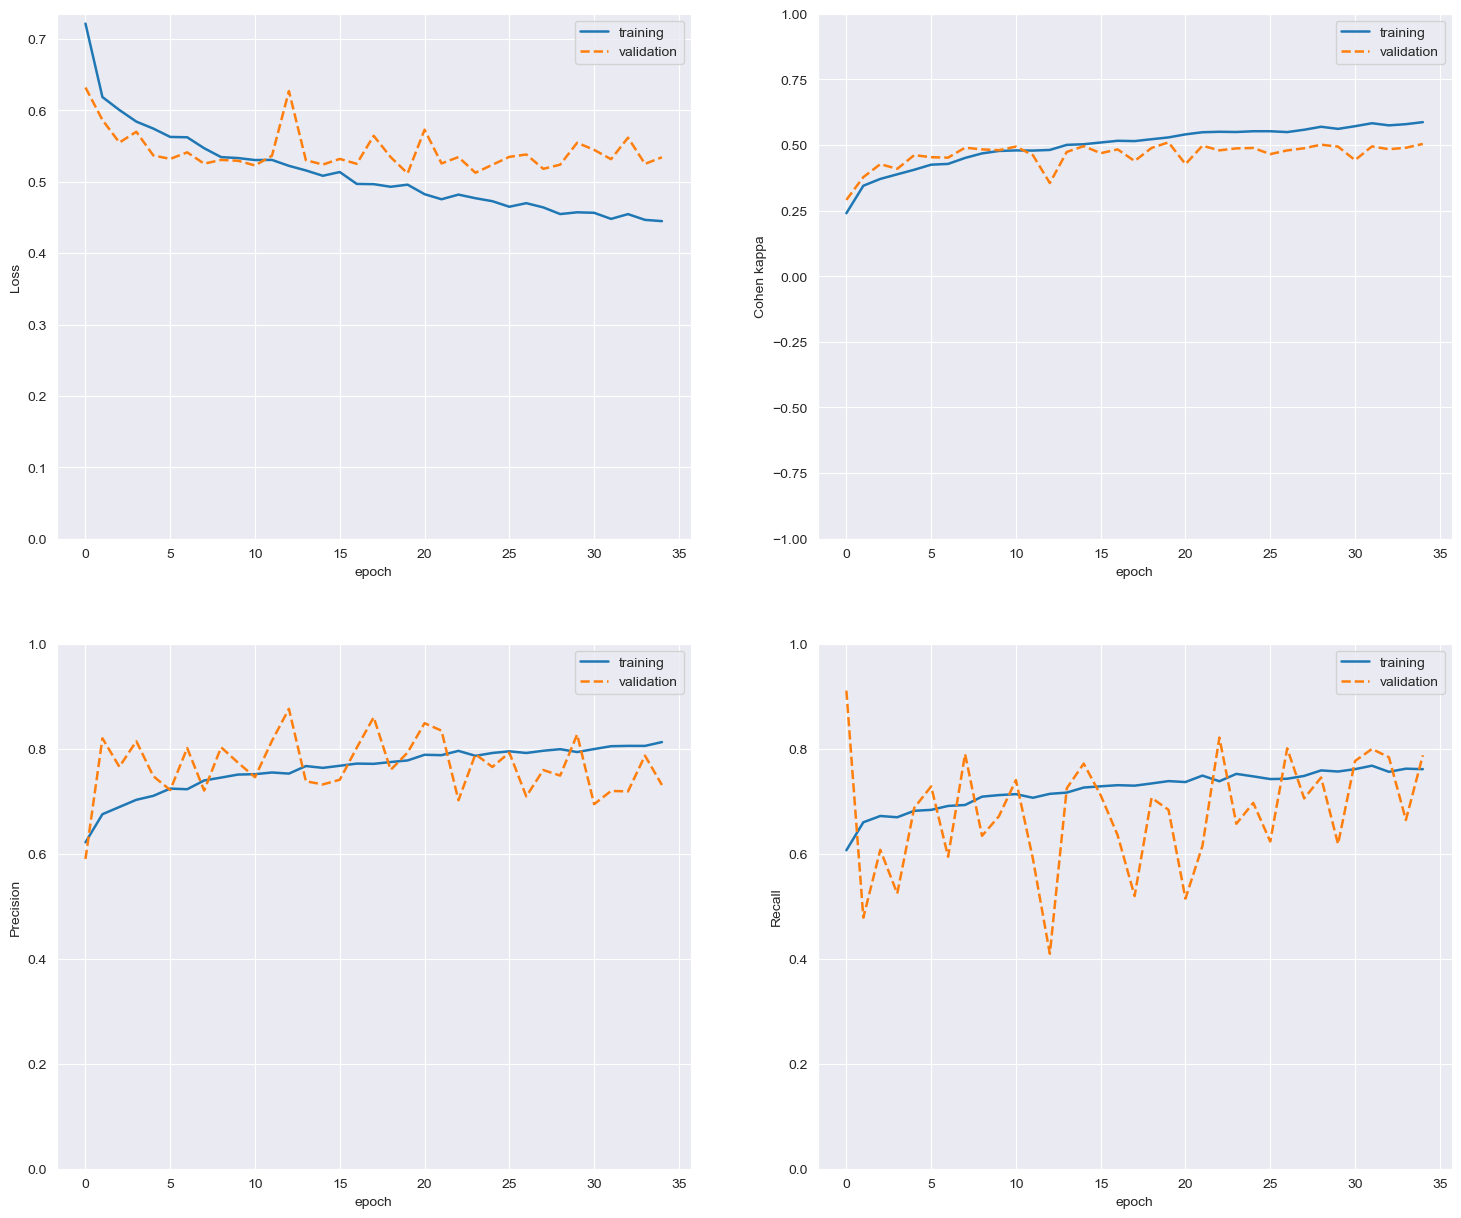

In [10]:
new_model.save(save_path + model_name + '.keras')

plot_metrics(history)

In [11]:
new_model.evaluate(validation_generator)
new_model.evaluate(test_generator)

    # Make predictions using the validation generator
y_valid_pred_prob = new_model.predict(validation_generator)
y_valid_pred = (y_valid_pred_prob > 0.5).astype(int)
y_valid = validation_generator.classes
print("Classification Report:")
print(classification_report(y_valid, y_valid_pred))

y_pred_prob = new_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_test = test_generator.classes
print("Classification Report:")
print(classification_report(y_test, y_pred))

105/105 [==============================] - 17s 145ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       848
           1       0.79      0.67      0.72       828

    accuracy                           0.75      1676
   macro avg       0.75      0.75      0.74      1676
weighted avg       0.75      0.75      0.74      1676

36/36 [==============================] - 2s 62ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       285
           1       0.69      0.73      0.71       278

    accuracy                           0.70       563
   macro avg       0.70      0.70      0.70       563
weighted avg       0.70      0.70      0.70       563



<Figure size 400x600 with 0 Axes>

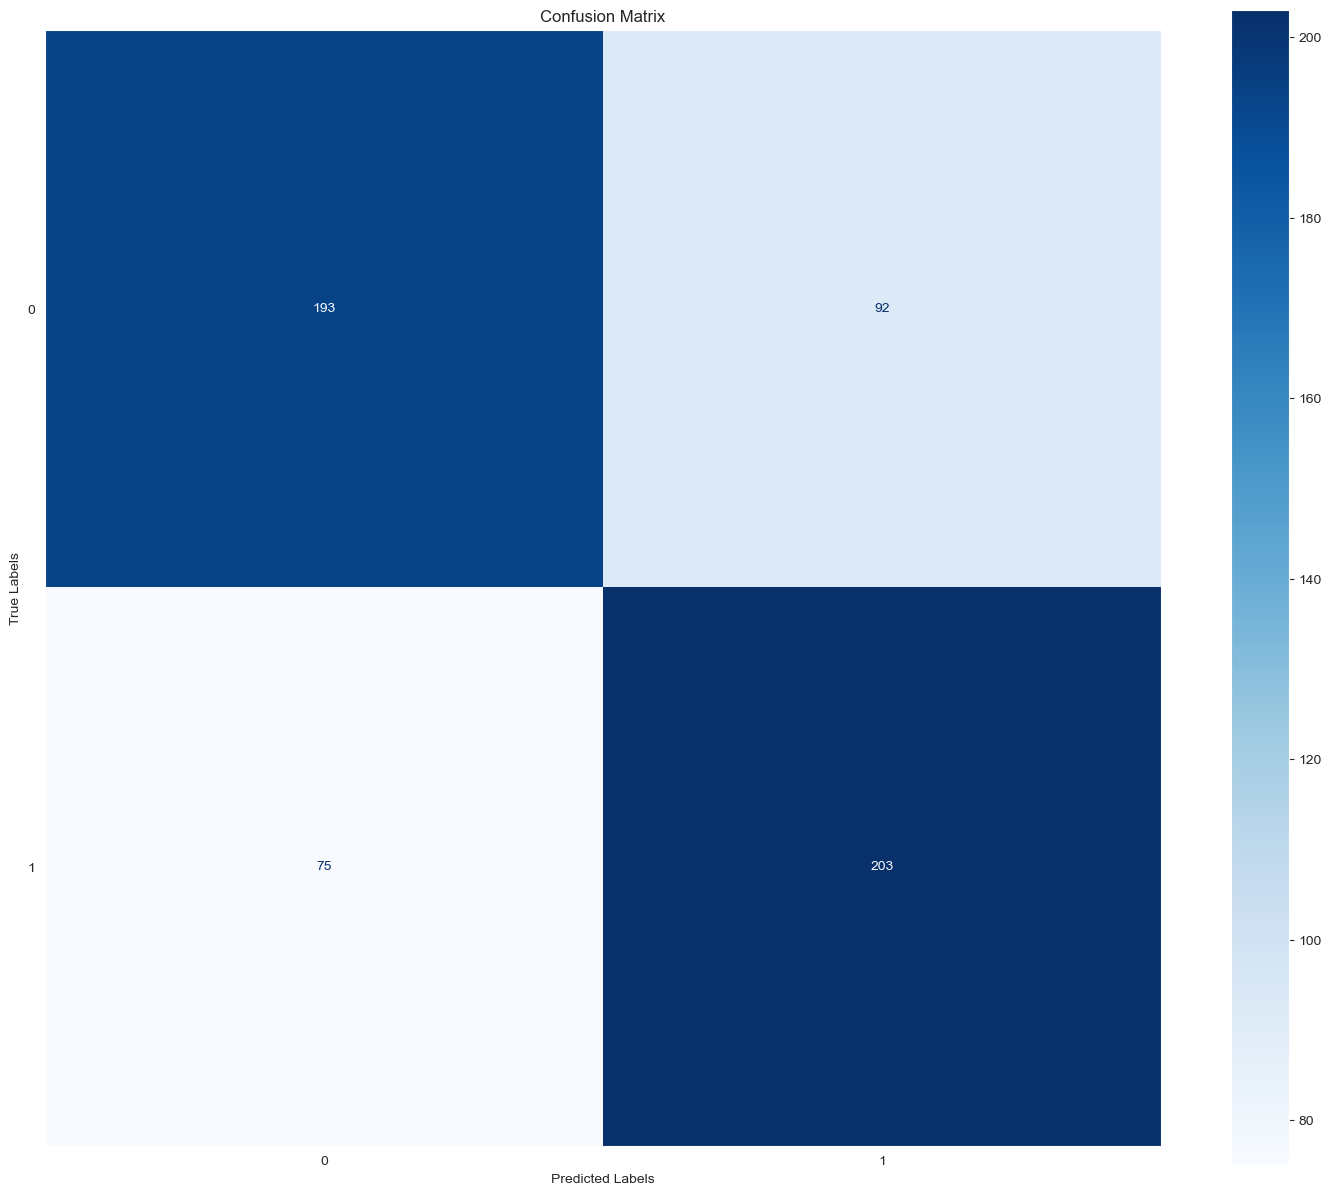

In [12]:

conf_matrix = confusion_matrix(y_test, y_pred)

# Create ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(4, 6))  # Adjust the figure size as needed
cm_display.plot(cmap=plt.cm.Blues)  # You can choose any colormap you prefer
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.grid(False)  # Turn off grid
plt.savefig(save_path + model_name + "_confusion_matrix.jpg")
plt.show()


In [13]:
history_df = pd.DataFrame(history.history)
save_history(model_name, history_df)

new_model.save(save_path + model_name + "_pt_imagenet-{new_model.count_params()}.h5")
densenet.save(save_path + model_name + ".h5")

densenet.trainable = True

new_model.compile(
        optimizer=tf.keras.optimizers.Adam(
            1e-5
        ),  # we need small learning rate to avoid catastrophic forgetting
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

model_name = 'finetuned_' + architecture + "_" + target_category

model_path = save_path + '_best_' + model_name + '.keras'
model_checkpoint = ModelCheckpoint(filepath=model_path,
                                       monitor="val_cohen_kappa",
                                       save_best_only=True)

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_cohen_kappa",
        verbose=1,
        patience=4,
        mode="max",
        factor=0.2,
        min_lr=1e-10,
    )

Training history saved to: C:/Users/raouf/Desktop/pfe/history/final/densenet/XR_SHOULDER/DenseNet_XR_SHOULDER_history.xlsx


In [14]:
history = new_model.fit(train_generator,
                            # steps_per_epoch=len(df_train) // batch_size,
                            validation_data=validation_generator,
                            # validation_steps=len(df_valid) // batch_size,
                            epochs=fine_tuning_epochs,
                            shuffle=shuffle,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau])


Epoch 1/50
419/419 [==============================] - 116s 242ms/step - loss: 0.5102 - tp: 2613.0000 - fp: 824.0000 - tn: 2824.0000 - fn: 1005.0000 - binary_acc: 0.7483 - precision: 0.7603 - recall: 0.7222 - f1_score: 0.7408 - roc_auc: 0.8227 - pr_auc: 0.8311 - cohen_kappa: 0.4964 - val_loss: 0.5130 - val_tp: 533.0000 - val_fp: 134.0000 - val_tn: 714.0000 - val_fn: 295.0000 - val_binary_acc: 0.7440 - val_precision: 0.7991 - val_recall: 0.6437 - val_f1_score: 0.7130 - val_roc_auc: 0.8320 - val_pr_auc: 0.8305 - val_cohen_kappa: 0.4868 - lr: 1.0000e-05
Epoch 2/50
419/419 [==============================] - 97s 230ms/step - loss: 0.4699 - tp: 2495.0000 - fp: 632.0000 - tn: 2731.0000 - fn: 845.0000 - binary_acc: 0.7797 - precision: 0.7979 - recall: 0.7470 - f1_score: 0.7716 - roc_auc: 0.8559 - pr_auc: 0.8644 - cohen_kappa: 0.5592 - val_loss: 0.5040 - val_tp: 496.0000 - val_fp: 79.0000 - val_tn: 769.0000 - val_fn: 332.0000 - val_binary_acc: 0.7548 - val_precision: 0.8626 - val_recall: 0.5990 

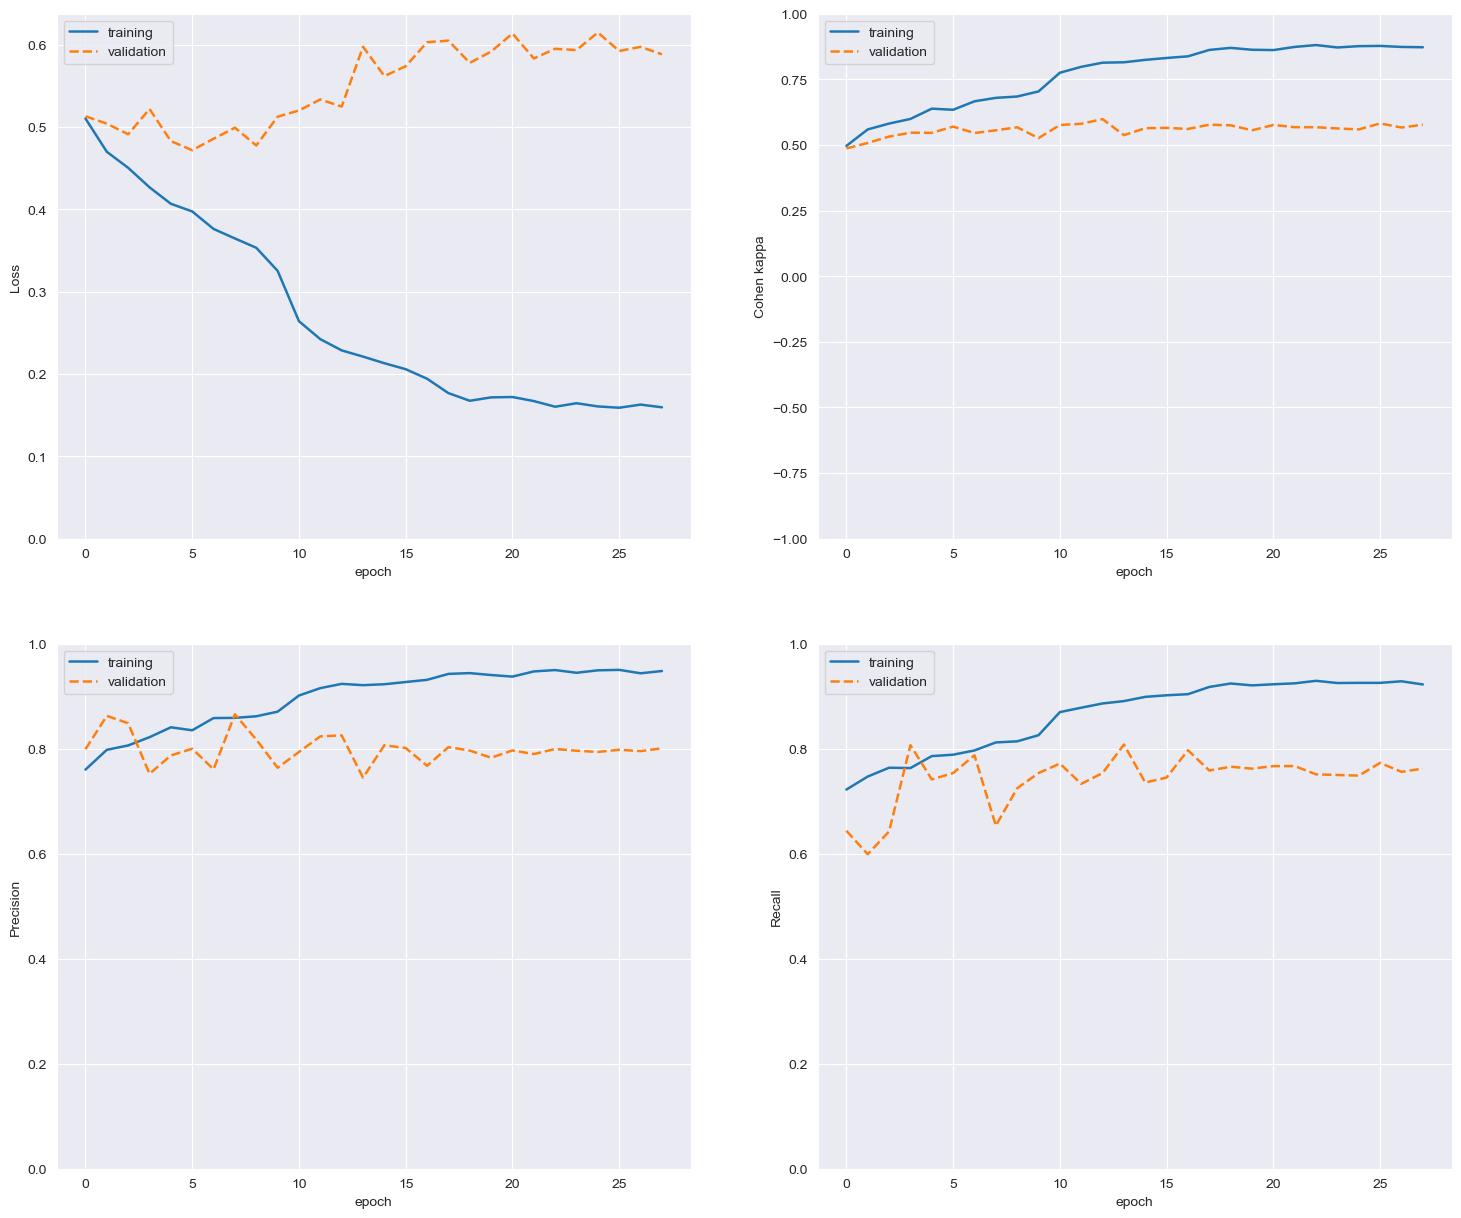

In [15]:
new_model.save(save_path + model_name + '.keras')
plot_metrics(history)

In [16]:
new_model.evaluate(validation_generator)
new_model.evaluate(test_generator)

# Make predictions using the validation generator
y_valid_pred_prob = new_model.predict(validation_generator)
y_valid_pred = (y_valid_pred_prob > 0.5).astype(int)
y_valid = validation_generator.classes
print("Classification Report:")
print(classification_report(y_valid, y_valid_pred))

# Make predictions using the test generator
y_pred_prob = new_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_test = test_generator.classes
print("Classification Report:")
print(classification_report(y_test, y_pred))

105/105 [==============================] - 18s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       848
           1       0.79      0.74      0.77       828

    accuracy                           0.78      1676
   macro avg       0.78      0.78      0.78      1676
weighted avg       0.78      0.78      0.78      1676

36/36 [==============================] - 2s 63ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       285
           1       0.74      0.83      0.78       278

    accuracy                           0.77       563
   macro avg       0.78      0.78      0.77       563
weighted avg       0.78      0.77      0.77       563



<Figure size 400x600 with 0 Axes>

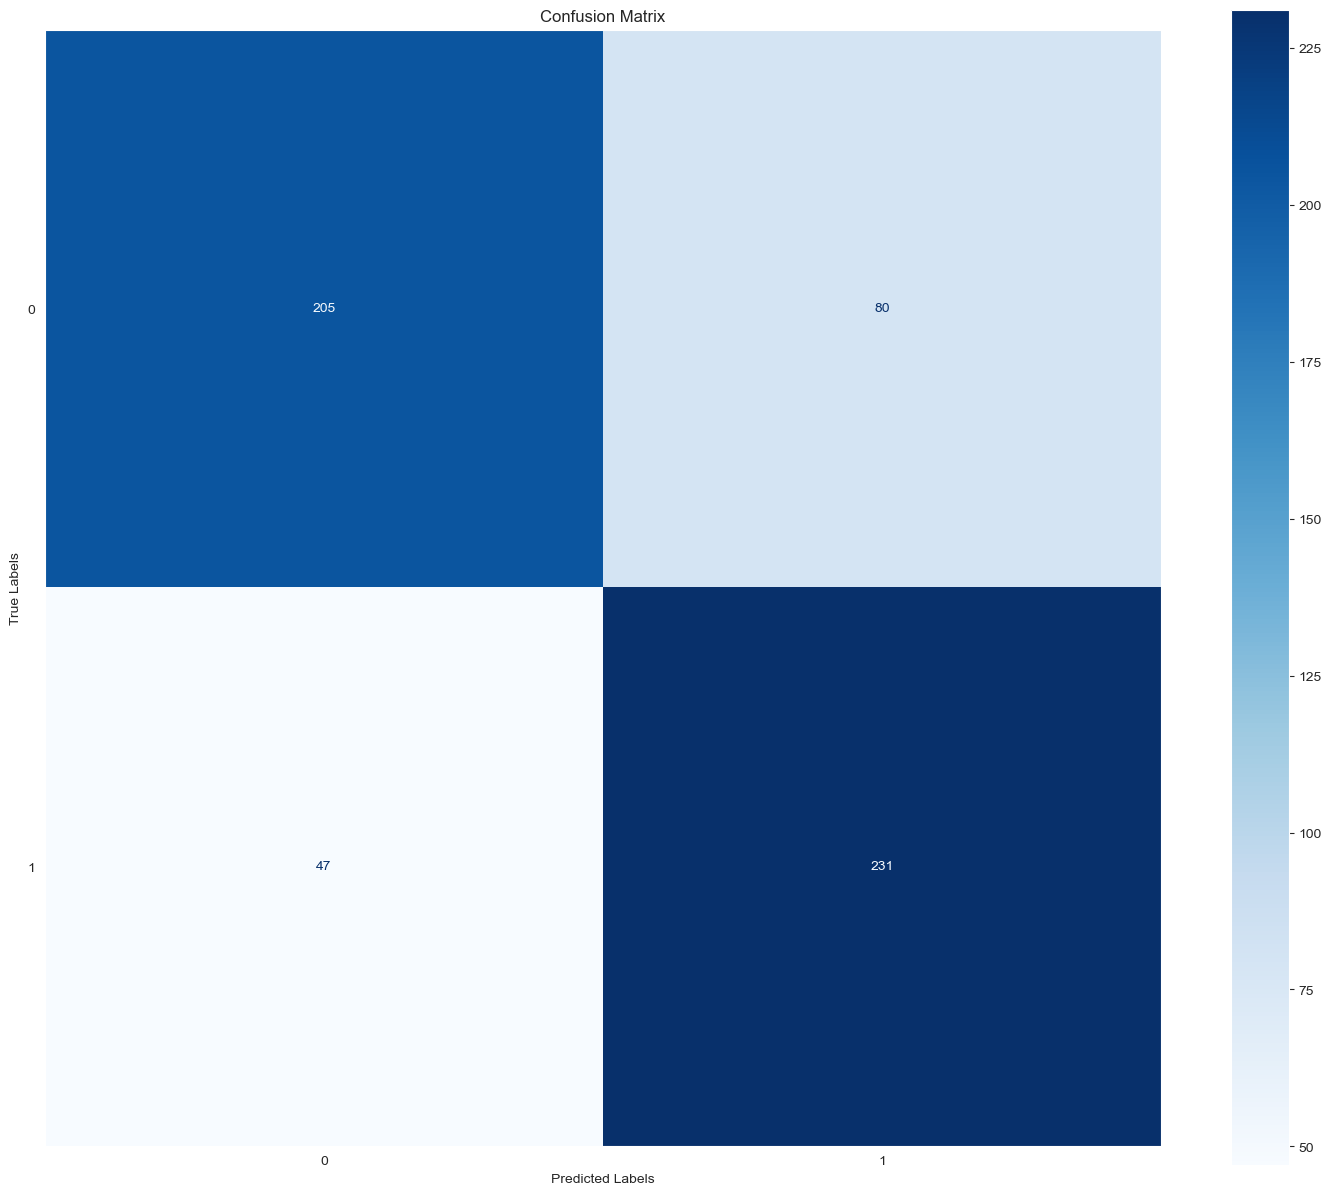

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Create ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(4, 6))  # Adjust the figure size as needed
cm_display.plot(cmap=plt.cm.Blues)  # You can choose any colormap you prefer
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.grid(False)  # Turn off grid
plt.savefig(save_path + model_name + "_confusion_matrix.jpg")
plt.show()

In [18]:
history_df = pd.DataFrame(history.history)
save_history(model_name, history_df)

Training history saved to: C:/Users/raouf/Desktop/pfe/history/final/densenet/XR_SHOULDER/finetuned_DenseNet_XR_SHOULDER_history.xlsx
